这篇文章通过 手写数字识别 来讨论分类问题

In [1]:
# 准备工作
#准备工作

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# 基本包的导入
import numpy as np
import os

# 画图相关
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# 忽略警告
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='internal')

# 图片存储目录
PROJECT_ROOT_DIR = '../'
CHAPTER_ID = 'classifiction'
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("保存图片:", fig_id)
    
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### MNIST 数据集


作为机器学习的hello world 项目，每当有新的机器学习算法时，该数据集就会被用于评估该模型的性能。

In [2]:
from sklearn.datasets import fetch_mldata 
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

如上方法通过 函数从网络上下载数据集，默认保存在 ` $HOME/scikit_learn_data.`目录。  
通过sklearn 下载的数据都有以下结构：  
1. DESCR：数据集的描述
2. data： 数据集的数据，每行是一个实例， 每列是一个特征。
3. target: 数据集的标签，即需要预测的值。

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

如上，包含该70000张图片，每张图片有28 * 28 个像素，共计784个特征。   
可以对每张图片进行可视化。

保存图片: some_digit_plot


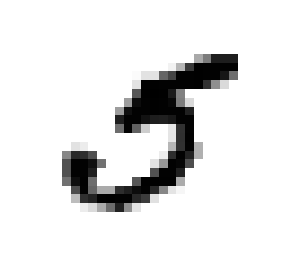

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
save_fig("some_digit_plot")
plt.show()

In [7]:
y[36000] #可以看到图片和标签都为5.

5.0

In [8]:
# 定义一个函数来查看图片
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")

保存图片: more_digits_plot


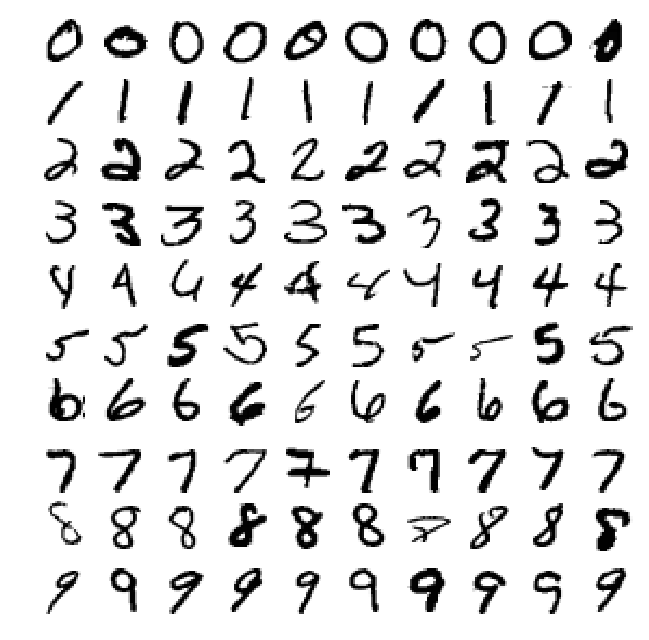

In [9]:
# 查看更多图片， 10 * 10
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row: (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(9, 9))
example_images = np.r_[X[:12000:600], X[13000:30600:600],  X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [10]:
# 切分测试集用于后续预测
X_train, y_train, X_test, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
# 由于该训练集对于顺序没有要求，不像股票数据或者天气数据。不是一般性，将其随机打乱
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y[shuffle_index]

### 训练一个二元分类器

从一个简单的为开始识别手写数字。首先判断一个实例是否为5.  
目标向量：

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
y_train_5

array([False, False,  True, ..., False, False, False])

现在可以找一个分类器对其训练。从 随机梯度下降分类器开始，优点在神将网络中也有提到，能快速处理大的数据集, 非常适合在线学习。

In [13]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])  # 可以看到对图片 5 预测正确， 返回true。

array([ True])

### 评估性能

评估分类模型的精确度要比回归模型复杂的多。下面使用交叉验证来对该模型进行评估：

In [14]:
# 交叉验证， 为了保证随机抽样，可以自定义交叉验证方法，进行随机抽样。
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96095, 0.96475, 0.96685])

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    
    X_test_folds = X_train[test_index]
    y_test_folds = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))
    

0.95325
0.9632
0.94975


In [16]:
# 看起来精确度还不错，下面定义一个最简单的分类器：
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) #永远返回0， 即预测等于5失败。

In [17]:
# 猜一下精确度
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9099 , 0.90995, 0.9091 ])

上述结果也有90的精确度，因为对于本次训练来说，不是5的比率在90%， 因此无论怎么训练，精确度最低都在90%。  
这说明了为什么精度通常不是用于分类器的首选性能度量， 特别是在某些类出现的比较频繁时。

### Confusion Matrix : 混淆矩阵

In [18]:
# 使用cross_val_predict
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

该函数与cross_val_score()类似，不过结果不是交叉验证的分数，而是每个测试fold的预测值。
这意味着可以得到一个 “清晰” 的预测值， 即该值所对应的实例不参与训练。

In [22]:
# 得到混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52849,  1730],
       [  834,  4587]])

得到如上混淆矩阵：每行代表真实值，每列代表预测值。
比如第一行表示 为非5(nagative class)的图像数， 其中52849张( true nagative) 预测分类正确；1730张(false nagative) 图片预测失败。
第二行表示 为5(positive class) 的图像数，843预测失败，4587张测成功，共计60000张图片。

最理想的模型计算得到的混淆只包括 true positives 和 true negatives 两项。


In [23]:
confusion_matrix(y_train_5, y_train_5) #假设y_train_5就是预测值。

array([[54579,     0],
       [    0,  5421]])

混淆矩阵包含太多可用的信息。可以使用以下方法衡量分类器的准确度。  
precision = TP / (TP + FP)

这里存在一个问题。假设训练集中只有单一的正确值(5的图片只有一张)， 那么预测正确的话，精确度就是100%。
但是模型一般会忽略正确值而预测错误，因此这种精确度 不是非常有用。  
因此经常需要结合 recall 这种衡量方法， 也叫做 sensitivisy 和 true positive rate。  
计算方法为  recall = TP / (TP + FN), 通常表示预测正确的占比。  

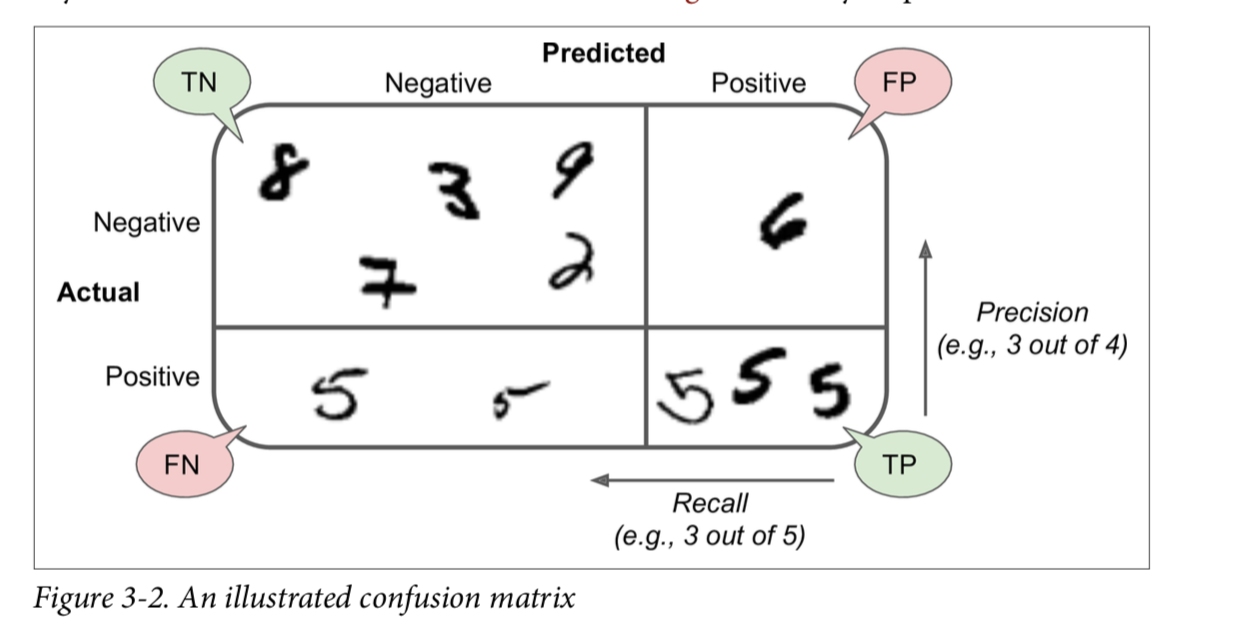

In [28]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # 4587 / (4587 + 1730)

0.726135823967073

In [29]:
recall_score(y_train_5, y_train_pred) # 4587 / (4587 + 834)

0.8461538461538461

以上结果相比之前的度量方法有不同。  
比如只有73%的精确度，并且只识别出了84%的正确图片5.

recall 越高，说明模型对正样本的识别能力越强，precision 体现了模型对负样本的区分能力，precision越高，说明模型对负样本的区分能力越强。  
F1-score 是两者的综合。F1-score 越高，说明分类模型越稳健。

更方便的，可以将精确度和召回率 组合为一个度量方法， 称为F1 分数，可以理解为两个度量的调和平均值。  
F1可以用于不同分类器的比较。  
此计算方法会加重 较小值的权重，因此在精确度和recall 都很高且接近的时候，才可以较高的F1分数。
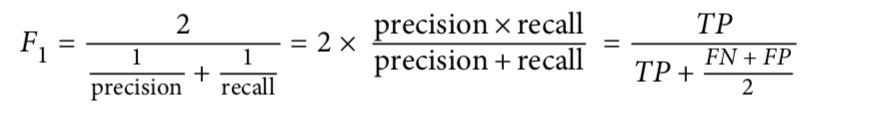

In [31]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7815641506219116

F1评分倾向于具有相似精度和召回率的分类器。但是某个情况比较在意精确度，某些情况比较在意recall。  
但是不可能增加精确度的同时减少recall， 这称为 `precision/recall tradeoff`